In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.model_selection import GridSearchCV, PredefinedSplit, ParameterGrid
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

from lightgbm import LGBMClassifier

In [2]:
# 1. Load data
train = pd.read_csv("../gen/data_def_train_folds.csv")
test  = pd.read_csv("../gen/data_def_test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

/var/folders/p2/b69xrmz146zc98k0yh6ylk1w0000gp/T/ipykernel_25593/1890095929.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("data_def_train_folds.csv")


Train shape: (206068, 24)
Test shape: (88315, 23)


/var/folders/p2/b69xrmz146zc98k0yh6ylk1w0000gp/T/ipykernel_25593/1890095929.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  test  = pd.read_csv("data_def_test.csv")


In [3]:
# 2. Create combined column for Phase 2 (intrinsic + extrinsic)
train["labels_1_2_intr_extr"] = (
    train[["labels_1_intrinsic", "labels_2_extrinsic"]]
    .fillna("")
    .agg("|".join, axis=1)
    .str.strip("|")
)

test["labels_1_2_intr_extr"] = (
    test[["labels_1_intrinsic", "labels_2_extrinsic"]]
    .fillna("")
    .agg("|".join, axis=1)
    .str.strip("|")
)

In [4]:
train.head()

,barcode,product_name,nutriscore,nova_group,mapped_category,labels_string,n_labels_total,labels_1_intrinsic,n_1_intrinsic,labels_2_extrinsic,...,n_additives,n_ingredients,main_mapped_category,label_tier,stratify_raw,stratify,split,nova_group_fold,nutriscore_fold,labels_1_2_intr_extr
0,554004509,Pain de mie sans gluten,c,4,3.1 Bread,NO_GLUTEN|NO_PRESERVATIVES,2,NO_GLUTEN|NO_PRESERVATIVES,2,NaN,...,2.0,22.0,3. Cereals & Starches,1,3. Cereals & Starches | 4,3. Cereals & Starches | 4,train,4,3,NO_GLUTEN|NO_PRESERVATIVES
1,2000002466,2 MINI BAGUETTES SANS GLUTEN,c,4,3.1 Bread,CROSSED_GRAIN|CROSSED_GRAIN_DZG|EU_ORGANIC_LOG...,5,NO_GLUTEN,1,CROSSED_GRAIN|CROSSED_GRAIN_DZG|EU_ORGANIC_LOG...,...,2.0,15.0,3. Cereals & Starches,2,3. Cereals & Starches | 4,3. Cereals & Starches | 4,train,4,3,NO_GLUTEN|CROSSED_GRAIN|CROSSED_GRAIN_DZG|EU_O...
2,2000003197,Véritable Andouille de Guémené,e,4,5.1 Processed meat,SMOKED_BEECH_WOOD,1,SMOKED_BEECH_WOOD,1,NaN,...,2.0,10.0,"5. Meat, Fish & Eggs",1,"5. Meat, Fish & Eggs | 4","5. Meat, Fish & Eggs | 4",train,1,1,SMOKED_BEECH_WOOD
3,2000010775,Escalope soja et blé,b,3,5.4 Meat,EVU_VEGETARIAN|VEGETARIAN,2,NaN,0,EVU_VEGETARIAN|VEGETARIAN,...,0.0,32.0,"5. Meat, Fish & Eggs",1,"5. Meat, Fish & Eggs | 3","5. Meat, Fish & Eggs | 3",train,1,3,EVU_VEGETARIAN|VEGETARIAN
4,8112100281,Pure Sesame Oil,c,2,6.1 Fats & oils,NON_GMO,1,NaN,0,NON_GMO,...,0.0,1.0,6. Fats & Sauces,1,6. Fats & Sauces | 2,6. Fats & Sauces | 2,train,4,4,NON_GMO


In [5]:
test.head()

,barcode,product_name,nutriscore,nova_group,mapped_category,labels_string,n_labels_total,labels_1_intrinsic,n_1_intrinsic,labels_2_extrinsic,...,countries,n_additives,n_ingredients,main_mapped_category,label_tier,stratify_raw,stratify,split,core_slice,labels_1_2_intr_extr
0,790200123,"Fine Chocolate Candy Bar, Dark Chocolate",c,4,9.3 Chocolate products,NO_GLUTEN,1,NO_GLUTEN,1,NaN,...,united-states,2.0,8.0,9. Sweet Products & Desserts,1,9. Sweet Products & Desserts | 4,9. Sweet Products & Desserts | 4,test,False,NO_GLUTEN
1,2000001780,Pizza Margherita,c,3,"7.2 Pizza, pies and quiche",EU_ORGANIC_LOGO,1,NaN,0,EU_ORGANIC_LOGO,...,france,0.0,35.0,7. Composite & Prepared Meals,1,7. Composite & Prepared Meals | 3,7. Composite & Prepared Meals | 3,test,False,EU_ORGANIC_LOGO
2,3004032145,Chinois Nature Décongelé,e,4,9.2 Pastries,UNFROZEN,1,UNFROZEN,1,NaN,...,france,11.0,48.0,9. Sweet Products & Desserts,1,9. Sweet Products & Desserts | 4,9. Sweet Products & Desserts | 4,test,False,UNFROZEN
3,8005158306,"Nuovo Pasta, Organic Ravioli, Butternut Squash",a,4,2.5 Potatoes,EU_ORGANIC_LOGO,1,NaN,0,EU_ORGANIC_LOGO,...,united-states,1.0,33.0,2. Fruits & Vegetables,1,2. Fruits & Vegetables | 4,2. Fruits & Vegetables | 4,test,False,EU_ORGANIC_LOGO
4,8295663177,Balsamic Vinegar Of Modena,c,4,6.2 Dressings and sauces,NON_GMO,1,NaN,0,NON_GMO,...,united-states|world,0.0,3.0,6. Fats & Sauces,1,6. Fats & Sauces | 4,6. Fats & Sauces | 4,test,False,NON_GMO


In [6]:
# 3. Target + folds
target = "nova_group"
fold_col = f"{target}_fold"

# Encode target variable
le = LabelEncoder()
y_train = le.fit_transform(train[target])
y_test = le.transform(test[target])

print("Class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Class mapping: {1: 0, 2: 1, 3: 2, 4: 3}


In [7]:
# 4. Define phases (name -> column)
phases = {
    "phase1_intrinsic": "labels_1_intrinsic",
    "phase2_intr+extr": "labels_1_2_intr_extr",
    "phase3_all_labels": "labels_string",
}

In [8]:
# 5. Define LightGBM hyperparameter grid
lgb_param_grid = {
    "n_estimators": [50, 100, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5],
    "num_leaves": [10, 30, 50]
}

all_phase_results = []
all_best_params = []


=== phase1_intrinsic – Using column 'labels_1_intrinsic' ===
Encoded label matrix shape (train): (206068, 359)
Encoded label matrix shape (test):  (88315, 359)

>>> Hyperparameter search using predefined 5-fold CV
Fitting 5 folds for each of 54 candidates, totalling 270 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['ARTIFICIAL_FLAVOR', 'ENRICHED_WITH_OMEGA3', 'HIGH_IN_CARBOHYDRATES', 'HIGH_IN_OMEGA3_AND_OMEGA6', 'HIGH_IN_PROTEIN_AND_FIBRE', 'HIGH_IN_VITAMIN_K', 'KETOGENIC', 'LOW_FODMAP', 'MINIMALLY_PROCESSED', 'NATURAL_SUGARS_FROM_OATS', 'NATURAL_SUGARS_UNALTERED', 'NOT_FROZEN', 'NO_ADDED_ARTIFICIAL_SWEETENERS', 'NO_ADDITIVES_PRESERVATIVES_COLORANTS', 'NO_ANHYDRIDES', 'NO_AROMA_COLORANT_PRESERVATIVE', 'NO_ARTIFICIAL_DYES', 'NO_ARTIFICIAL_E_NUMBERS', 'NO_ARTIFICIAL_PRESERVATIVES_FLAVOURS_DYES', 'NO_CARRAGEENAN', 'NO_CHEMICAL_INGREDIENTS', 'NO_CHEMICAL_TREATMENT', 'NO_CLEANING_AGENTS', 'NO_COLORANT_AROMA_PRESERVATIVE', 'NO_DYES_PRESERVATIVES_HYDROGENATED_FATS', 'NO_EXTRACTS', 'NO_FRUIT', 'NO_GARLIC_ONION', 'NO_GLUTEN_COLORANT_PRESERVATIVE', 'NO_HIGH_PRESSURE_PROCESSING', 'NO_HONEY', 'NO_LARD', 'NO_METAL_MOLD', 'NO_NUT_TRACES', 'NO_PALM_OIL_DERIVATIVES', 'NO_PHOSPHORIC_ACID', 'NO_POTATO_F


Best parameters for phase1_intrinsic:
  learning_rate: 0.1
  max_depth: 5
  n_estimators: 300
  num_leaves: 30
Best 5-fold balanced accuracy (train CV): 0.2776
Hyperparameter search time: 1015.55 s

>>> Final model training on full training data & test evaluation

=== Test Performance – phase1_intrinsic (Nutri-Score) ===
Accuracy:           0.5676
Balanced Accuracy:  0.2842
Precision (Macro):  0.6068
Recall (Macro):     0.2842
F1 (Macro):         0.2502
F1 (Micro):         0.5676
Train time (full train):   6.47 s
Predict time (test set):   2.90 s

Detailed Classification Report:
              precision    recall  f1-score   support

           1       0.53      0.11      0.18     12931
           2       0.75      0.01      0.02      3658
           3       0.58      0.04      0.08     22722
           4       0.57      0.97      0.72     49004

    accuracy                           0.57     88315
   macro avg       0.61      0.28      0.25     88315
weighted avg       0.57      0.57

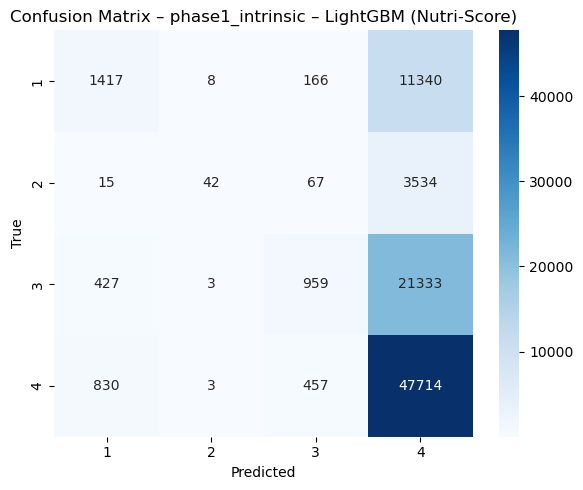


=== phase2_intr+extr – Using column 'labels_1_2_intr_extr' ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['ARTIFICIAL_FLAVOR', 'CERT_BIODYNAMIC', 'COASTAL_FISHING', 'DLG_BRONZE_MEDAL', 'ENRICHED_WITH_OMEGA3', 'EU_ORGANIC_CERT_FB', 'EU_ORGANIC_CERT_MY', 'GLUTEN_FREE_VEGAN', 'GLUTEN_LACTOSE_SULFITE_FREE', 'HAZELNUT_FREE', 'HIGH_IN_CARBOHYDRATES', 'HIGH_IN_OMEGA3_AND_OMEGA6', 'HIGH_IN_PROTEIN_AND_FIBRE', 'HIGH_IN_VITAMIN_K', 'INVALID_OR_ERROR', 'ISO_50001', 'KETOGENIC', 'LACTOSE_DAIRY_FREE', 'LOW_FODMAP', 'MAY_CONTAIN_SULPHITES', 'MILK_DERIVATIVE_FREE', 'MINIMALLY_PROCESSED', 'NATURAL_SUGARS_FROM_OATS', 'NATURAL_SUGARS_UNALTERED', 'NOT_FROZEN', 'NO_ADDED_ARTIFICIAL_SWEETENERS', 'NO_ADDITIVES_PRESERVATIVES_COLORANTS', 'NO_ANHYDRIDES', 'NO_ANIMAL_INGREDIENTS', 'NO_AROMA_COLORANT_PRESERVATIVE', 'NO_ARTIFICIAL_DYES', 'NO_ARTIFICIAL_E_NUMBERS', 'NO_ARTIFICIAL_PRESERVATIVES_FLAVOURS_DYES', 'NO_CARRAGEENAN', 'NO_CHEMICAL_INGREDIENTS', 'NO_CHEMICAL_TREATMENT', 'NO_CLEANING_AGENTS', 'NO_COL

Encoded label matrix shape (train): (206068, 808)
Encoded label matrix shape (test):  (88315, 808)

>>> Hyperparameter search using predefined 5-fold CV
Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best parameters for phase2_intr+extr:
  learning_rate: 0.1
  max_depth: 5
  n_estimators: 300
  num_leaves: 30
Best 5-fold balanced accuracy (train CV): 0.3757
Hyperparameter search time: 1195.60 s

>>> Final model training on full training data & test evaluation

=== Test Performance – phase2_intr+extr (Nutri-Score) ===
Accuracy:           0.6178
Balanced Accuracy:  0.3779
Precision (Macro):  0.5900
Recall (Macro):     0.3779
F1 (Macro):         0.3887
F1 (Micro):         0.6178
Train time (full train):   4.25 s
Predict time (test set):   2.51 s

Detailed Classification Report:
              precision    recall  f1-score   support

           1       0.53      0.24      0.33     12931
           2       0.71      0.03      0.07      3658
           3       0.44      0.35  

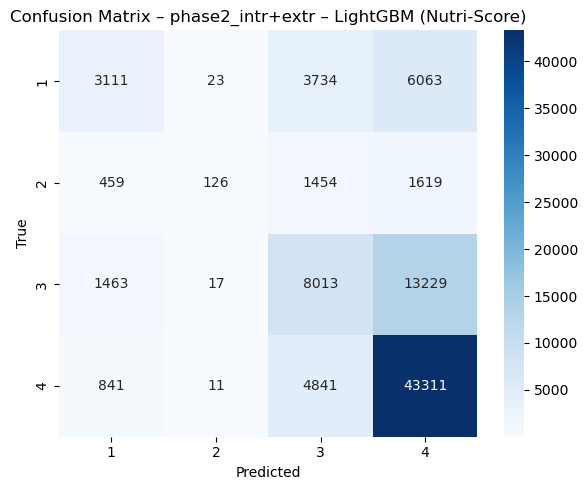


=== phase3_all_labels – Using column 'labels_string' ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['ARTIFICIAL_FLAVOR', 'CARREFOUR_CLASSIC', 'CERT_BIODYNAMIC', 'COASTAL_FISHING', 'DLG_BRONZE_MEDAL', 'ENRICHED_WITH_OMEGA3', 'EU_ORGANIC_CERT_FB', 'EU_ORGANIC_CERT_MY', 'GLUTEN_FREE_VEGAN', 'GLUTEN_LACTOSE_SULFITE_FREE', 'GOLD_MEDAL_GENERIC', 'GOLD_MEDAL_MILK_GRADE_A', 'HAZELNUT_FREE', 'HIGH_IN_CARBOHYDRATES', 'HIGH_IN_OMEGA3_AND_OMEGA6', 'HIGH_IN_PROTEIN_AND_FIBRE', 'HIGH_IN_VITAMIN_K', 'INVALID_OR_ERROR', 'ISO_50001', 'KETOGENIC', 'LACTOSE_DAIRY_FREE', 'LOW_FODMAP', 'MAY_CONTAIN_SULPHITES', 'MILK_DERIVATIVE_FREE', 'MINIMALLY_PROCESSED', 'NATURAL_SUGARS_FROM_OATS', 'NATURAL_SUGARS_UNALTERED', 'NOT_FROZEN', 'NO_ADDED_ARTIFICIAL_SWEETENERS', 'NO_ADDITIVES_PRESERVATIVES_COLORANTS', 'NO_ANHYDRIDES', 'NO_ANIMAL_INGREDIENTS', 'NO_AROMA_COLORANT_PRESERVATIVE', 'NO_ARTIFICIAL_DYES', 'NO_ARTIFICIAL_E_NUMBERS', 'NO_ARTIFICIAL_PRESERVATIVES_FLAVOURS_DYES', 'NO_CARRAGEENAN', 'NO_CHEMICA

Encoded label matrix shape (train): (206068, 870)
Encoded label matrix shape (test):  (88315, 870)

>>> Hyperparameter search using predefined 5-fold CV
Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best parameters for phase3_all_labels:
  learning_rate: 0.1
  max_depth: 5
  n_estimators: 300
  num_leaves: 50
Best 5-fold balanced accuracy (train CV): 0.3769
Hyperparameter search time: 1279.78 s

>>> Final model training on full training data & test evaluation

=== Test Performance – phase3_all_labels (Nutri-Score) ===
Accuracy:           0.6187
Balanced Accuracy:  0.3796
Precision (Macro):  0.5630
Recall (Macro):     0.3796
F1 (Macro):         0.3913
F1 (Micro):         0.6187
Train time (full train):   4.40 s
Predict time (test set):   2.56 s

Detailed Classification Report:
              precision    recall  f1-score   support

           1       0.54      0.24      0.34     12931
           2       0.59      0.04      0.07      3658
           3       0.44      0.35

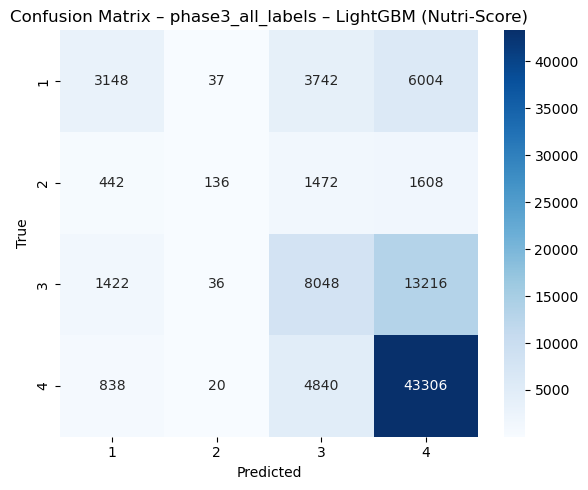

In [9]:
# 6. Loop over phases
for phase_name, label_col in phases.items():
    print("\n" + "="*90)
    print(f"=== {phase_name} – Using column '{label_col}' ===")
    print("="*90)

    # 6.1 Encode label features
    train[label_col] = train[label_col].fillna("")
    test[label_col]  = test[label_col].fillna("")

    train_labels = train[label_col].apply(lambda x: x.split("|") if x != "" else [])
    test_labels  = test[label_col].apply(lambda x: x.split("|") if x != "" else [])

    mlb = MultiLabelBinarizer(sparse_output=True)
    X_train_labels = mlb.fit_transform(train_labels)
    X_test_labels  = mlb.transform(test_labels)

    X_train_labels = X_train_labels.astype(np.float32)
    X_test_labels  = X_test_labels.astype(np.float32)

    print(f"Encoded label matrix shape (train): {X_train_labels.shape}")
    print(f"Encoded label matrix shape (test):  {X_test_labels.shape}")

    # 6.2 Hyperparameter tuning with predefined folds
    print("\n>>> Hyperparameter search using predefined 5-fold CV")

    fold_ids = train[fold_col].values
    test_fold = fold_ids - 1   # convert 1–5 > 0–4
    ps = PredefinedSplit(test_fold=test_fold)

    base_lgb = LGBMClassifier(
        objective="multiclass",
        random_state=42,
        n_jobs=-1,
        verbosity=-1,
        force_row_wise=True
    )

    grid = GridSearchCV(
        estimator=base_lgb,
        param_grid=lgb_param_grid,
        cv=ps,
        scoring="balanced_accuracy",
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )

    grid_start = time.perf_counter()
    grid.fit(X_train_labels, y_train)
    grid_end = time.perf_counter()
    grid_time = grid_end - grid_start

    best_params = grid.best_params_
    best_score = grid.best_score_

    print(f"\nBest parameters for {phase_name}:")
    for k, v in best_params.items():
        print(f"  {k}: {v}")
    print(f"Best 5-fold balanced accuracy (train CV): {best_score:.4f}")
    print(f"Hyperparameter search time: {grid_time:.2f} s")

    all_best_params.append({
        "Phase": phase_name,
        **best_params,
        "CV_BalAcc": best_score,
        "Hyperparam Time (s)": grid_time
    })

    # 6.3 Train final model on full training data, evaluate on test
    print("\n>>> Final model training on full training data & test evaluation")

    lgb_final = LGBMClassifier(
        objective="multiclass",
        random_state=42,
        n_jobs=-1,
        verbosity=-1,           
        force_row_wise=True,    
        **best_params
    )

    train_start = time.perf_counter()
    lgb_final.fit(X_train_labels, y_train)
    train_end = time.perf_counter()
    train_time = train_end - train_start

    pred_start = time.perf_counter()
    y_pred_test = lgb_final.predict(X_test_labels)
    pred_end = time.perf_counter()
    pred_time = pred_end - pred_start

    # Metrics
    acc_test = accuracy_score(y_test, y_pred_test)
    bal_acc_test = balanced_accuracy_score(y_test, y_pred_test)
    precision_macro = precision_score(y_test, y_pred_test, average='macro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred_test, average='macro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred_test, average='macro', zero_division=0)
    f1_micro = f1_score(y_test, y_pred_test, average='micro', zero_division=0)

    print(f"\n=== Test Performance – {phase_name} (Nutri-Score) ===")
    print(f"Accuracy:           {acc_test:.4f}")
    print(f"Balanced Accuracy:  {bal_acc_test:.4f}")
    print(f"Precision (Macro):  {precision_macro:.4f}")
    print(f"Recall (Macro):     {recall_macro:.4f}")
    print(f"F1 (Macro):         {f1_macro:.4f}")
    print(f"F1 (Micro):         {f1_micro:.4f}")
    print(f"Train time (full train):   {train_time:.2f} s")
    print(f"Predict time (test set):   {pred_time:.2f} s")

    class_names = [str(c) for c in le.classes_]
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred_test, target_names=class_names, zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix – {phase_name} – LightGBM (Nutri-Score)")
    plt.tight_layout()
    plt.show()

    # Store results
    all_phase_results.append({
        "Phase": phase_name,
        "CV_BalAcc": best_score,
        "Test_Accuracy": acc_test,
        "Test_BalAccuracy": bal_acc_test,
        "Precision (Macro)": precision_macro,
        "Recall (Macro)": recall_macro,
        "F1 (Macro)": f1_macro,
        "F1 (Micro)": f1_micro,
        "Train Time (s)": train_time,
        "Predict Time (s)": pred_time,
        "Hyperparam Time (s)": grid_time
    })

In [10]:
# 7. Summary tables
results_df = pd.DataFrame(all_phase_results)
best_params_df = pd.DataFrame(all_best_params)

print("\n=== Summary – Test Performance per Phase (LightGBM, Nova Group) ===")
print(results_df)

print("\n=== Best Hyperparameters per Phase ===")
print(best_params_df)

# Save results
results_df.to_csv("../results/lgb_nova_test_results.csv", index=False)
best_params_df.to_csv("../results/lgb_nova_best_params.csv", index=False)


=== Summary – Test Performance per Phase (LightGBM, Nutri-Score) ===
               Phase  CV_BalAcc  Test_Accuracy  Test_BalAccuracy  \
0   phase1_intrinsic   0.277560       0.567650          0.284236   
1   phase2_intr+extr   0.375739       0.617800          0.377877   
2  phase3_all_labels   0.376864       0.618672          0.379636   

   Precision (Macro)  Recall (Macro)  F1 (Macro)  F1 (Micro)  Train Time (s)  \
0           0.606771        0.284236    0.250165    0.567650        6.466738   
1           0.590003        0.377877    0.388689    0.617800        4.245936   
2           0.562960        0.379636    0.391258    0.618672        4.400846   

   Predict Time (s)  Hyperparam Time (s)  
0          2.895799          1015.548750  
1          2.511095          1195.604452  
2          2.561862          1279.781747  

=== Best Hyperparameters per Phase ===
               Phase  learning_rate  max_depth  n_estimators  num_leaves  \
0   phase1_intrinsic            0.1          5  